In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-dataset-tarik-a-rashid/Medicaldataset.csv


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## 1. Preprocessing

In [29]:
# Load the data
df = pd.read_csv('/kaggle/input/heart-attack-dataset-tarik-a-rashid/Medicaldataset.csv')
df.head()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Result
0,64,1,66,160,83,160.0,1.80,0.012,negative
1,21,1,94,98,46,296.0,6.75,1.060,positive
2,55,1,64,160,77,270.0,1.99,0.003,negative
3,64,1,70,120,55,270.0,13.87,0.122,positive
4,55,1,64,112,65,300.0,1.08,0.003,negative


In [30]:
# View shape
df.shape

(1319, 9)

In [31]:
# View basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1319 non-null   int64  
 1   Gender                    1319 non-null   int64  
 2   Heart rate                1319 non-null   int64  
 3   Systolic blood pressure   1319 non-null   int64  
 4   Diastolic blood pressure  1319 non-null   int64  
 5   Blood sugar               1319 non-null   float64
 6   CK-MB                     1319 non-null   float64
 7   Troponin                  1319 non-null   float64
 8   Result                    1319 non-null   object 
dtypes: float64(3), int64(5), object(1)
memory usage: 92.9+ KB


In [32]:
# Check null values
df.isnull().sum()

Age                         0
Gender                      0
Heart rate                  0
Systolic blood pressure     0
Diastolic blood pressure    0
Blood sugar                 0
CK-MB                       0
Troponin                    0
Result                      0
dtype: int64

In [33]:
# Check for duplicates
df.duplicated().sum()

0

In [34]:
# View summary statistics
df.describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


In [35]:
# Set random seed for reproducibility
np.random.seed(42)

In [36]:
# Encode categorical variables
# Gender is already encoded (0/1), encode Result (negative=0, positive=1)
df['Result'] = df['Result'].map({'negative': 0, 'positive': 1})

In [37]:
# Check for outliers using Z-score (threshold = 3)
z_scores = np.abs(stats.zscore(df[['Age', 'Heart rate', 'Systolic blood pressure', 
                                  'Diastolic blood pressure', 'Blood sugar', 'CK-MB', 'Troponin']]))
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outlier rows: {outliers.sum()}")

Number of outlier rows: 114


In [38]:
# Cap outliers at 99th percentile for numerical columns
num_cols = ['Age', 'Heart rate', 'Systolic blood pressure', 'Diastolic blood pressure', 
            'Blood sugar', 'CK-MB', 'Troponin']
for col in num_cols:
    percentile_99 = df[col].quantile(0.99)
    df[col] = np.clip(df[col], df[col].min(), percentile_99)

In [39]:
# Scale numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

In [40]:
# Check class imbalance
class_counts = df['Result'].value_counts(normalize=True)
print("Class distribution:\n", class_counts)

Class distribution:
 Result
1    0.614102
0    0.385898
Name: proportion, dtype: float64


#### **Analysis of Results**

**1. Outliers**
- 114 out of 1319 rows were flagged as outliers using a Z-score threshold of 3, or approximately 8.6% of the dataset.
- Significant but not unexpected given the presence of extreme values (e.g., Heart rate max of 1111 in the original df.describe()).
- Capping at the 99th percentile is therefore necessary to reduce effect of outliers

**2. Class imbalance**
- dataset is moderately imbalanced, with a 61:39 ratio favoring the positive class
- This imbalance could bias the model towards predicting heart attacks (positive class) more frequently.
- We’ll address this in the modeling phase using class weighting, SMOTE, or stratified sampling 

## 2. EDA

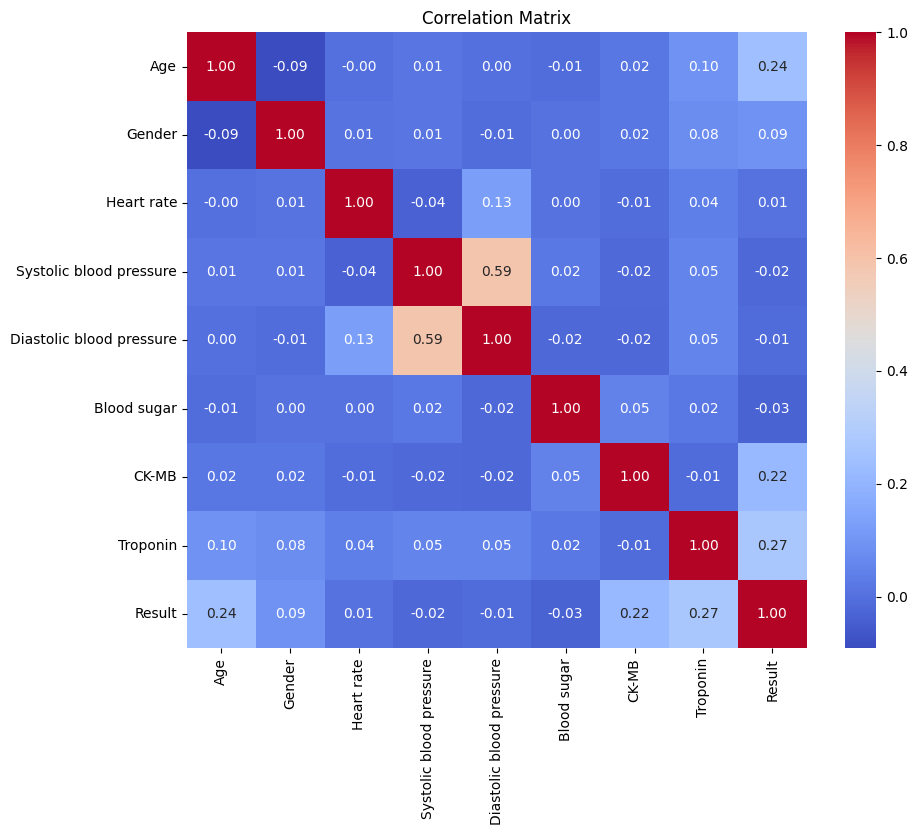

In [41]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

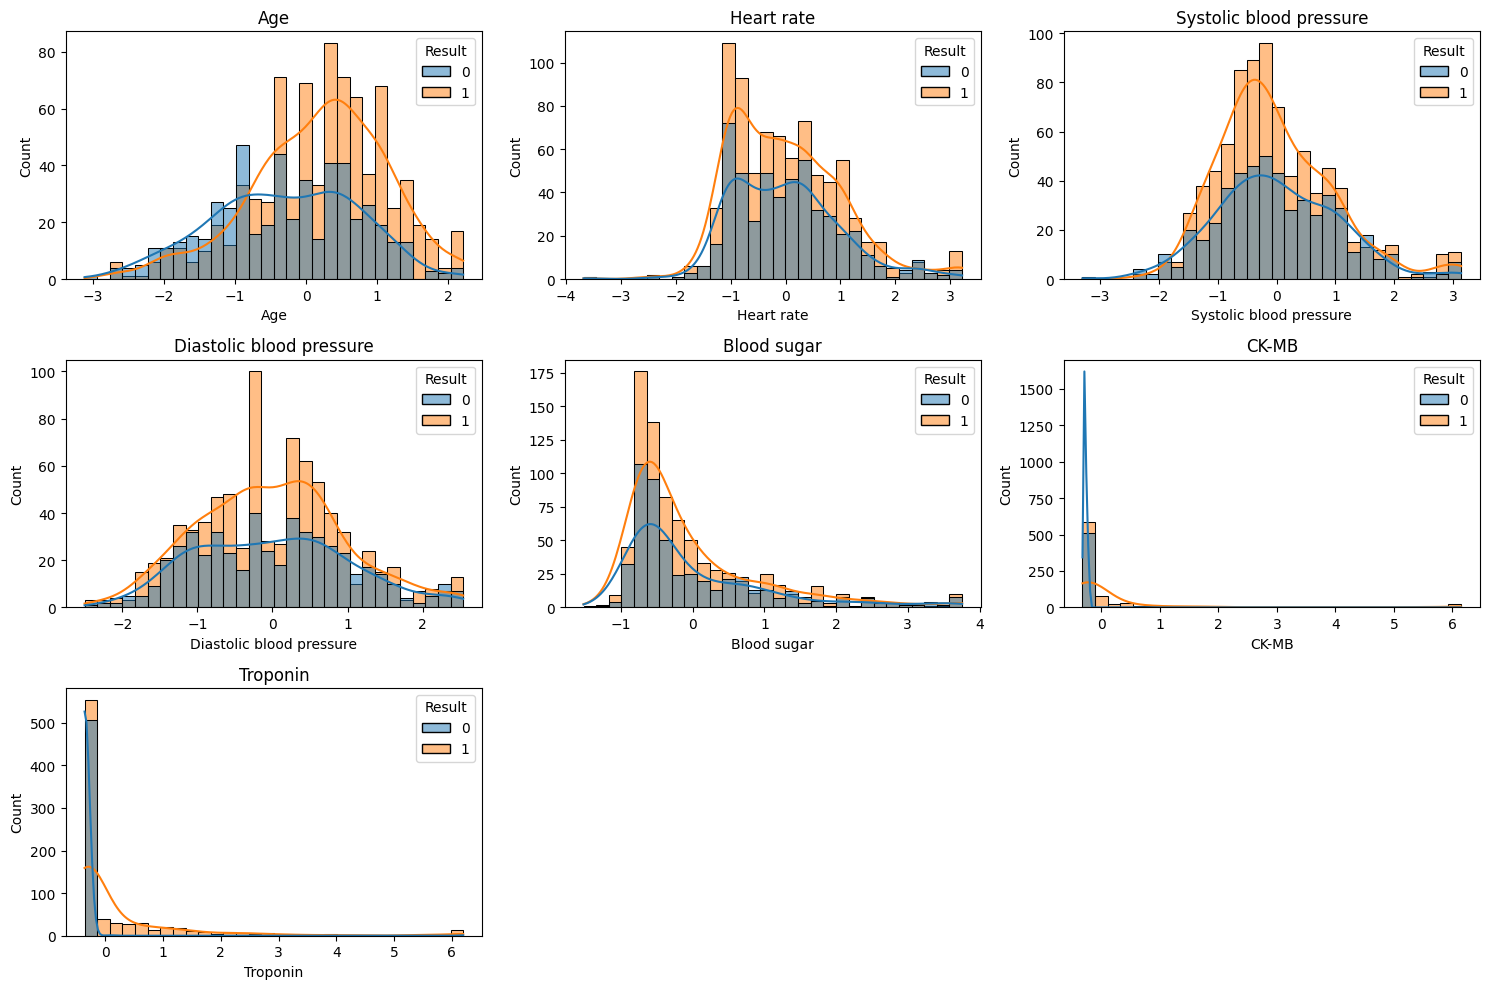

In [42]:
# Distribution of numerical features by Result 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, hue='Result', kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'{col}')
# Remove empty subplots (if any)
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])
plt.tight_layout()
plt.show()

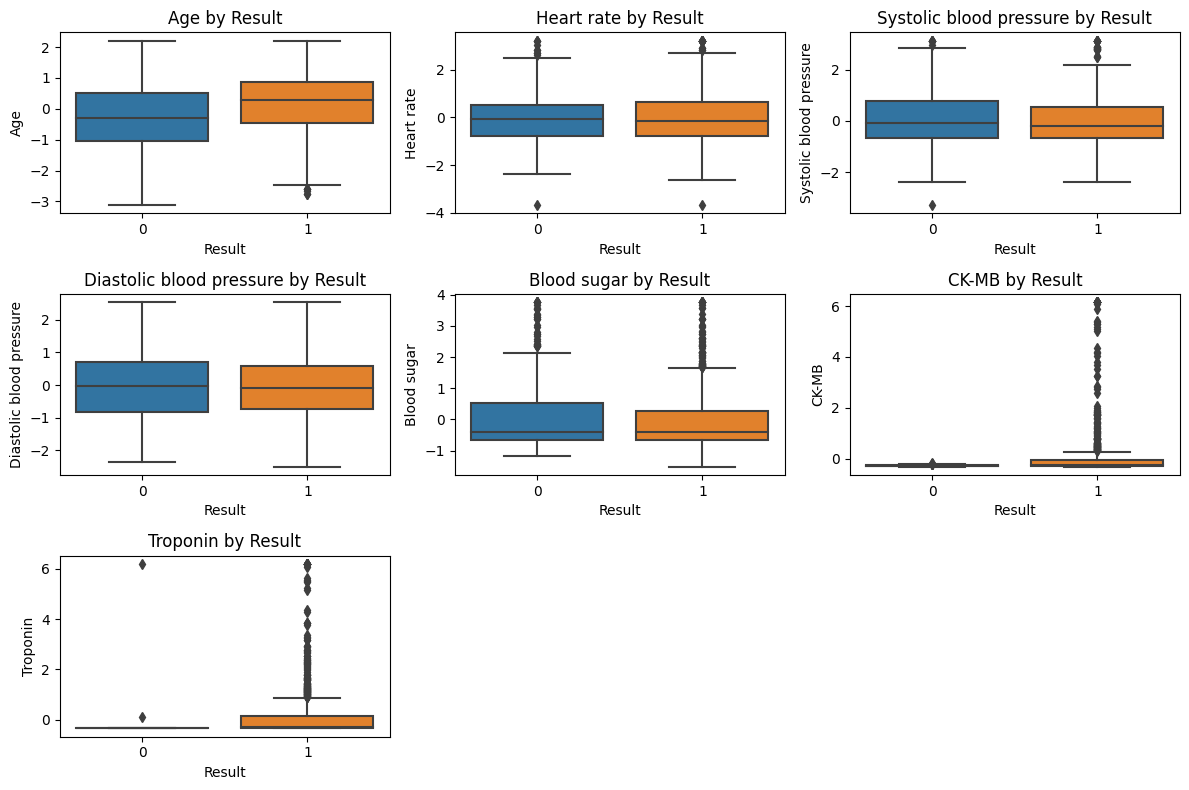

In [43]:
# Box plots for numerical features
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='Result', y=col, data=df)
    plt.title(f'{col} by Result')
plt.tight_layout()
plt.show()

#### **Analysis of Results**

***Note:** Positive class corresponds to Result = 1*

**1. Correlation Matrix** 

- **Strong correlations:**

  
    - Systolic blood pressure and Diastolic blood pressure: 0.59, indicating a moderate positive correlation. Expected as these metrics are physiologically related.
    - CK-MB and Result: 0.22, suggesting a weak but positive correlation. Higher CK-MB levels are associated with heart attacks
    - Troponin and Result: 0.27, the strongest correlation with the target variable. Troponin is a highly specific biomarker for heart muscle injury, so this correlation supports its predictive power.
  
- **Weak correlations:**

  
    - Most features (Age, Gender, Heart rate, Blood sugar) show very weak correlations with Result (ranging from -0.03 to 0.09), indicating they may not be strong linear predictors on their own.
    - No significant multicollinearity between features (all correlations < 0.6), so we can retain all features for modeling without immediate concern for redundancy.
    
- **Insight:** Troponin and CK-MB are likely to be key predictors due to their correlation with Result. Non-linear models like Random Forest and XGBoost may capture more complex relationships for features with weak linear correlations.

**2. Distributions**

- **Age:**
    - Distributions for both classes are similar, with slight shifts. The positive class has a slightly higher peak around older ages (after scaling, near 0 to 1). This supports the weak correlation (0.24) with Result.
    - Age may contribute to predictions but isn’t a strong differentiator alone.
  
- **Heart rate:**
    - Both classes show right-skewed distributions, but the positive class has a slightly broader spread. Extreme values are removed, and distributions are more normalized after capping,
    - Differences are subtle, suggesting Heart rate may not be a primary predictor.
  
- **Systolic and Diastolic blood pressure:**
    - Both features show overlapping distributions, with the positive class having a slightly lower mean for both (visible in the KDE curves shifting left for Result = 1).
    - These features may contribute to predictions, especially in combination with other features because of their weak negative correlations with Result.
      
- **Blood sugar:**
    - Distributions are heavily right-skewed, with the positive class showing a slightly higher tail. The overlap is significant.
    - Blood sugar may not be a strong discriminator, aligning with its weak correlation.
      
- **CK-MB:**
    - The positive class shows a heavier right tail, indicating higher CK-MB levels in heart attack patients, consistent with the correlation of 0.22.
    - CK-MB is a promising predictor, especially for non-linear models that can capture this skewed relationship.
      
- **Troponin:**
    - The most distinct separation: the positive class has a much heavier right tail, with many values extending beyond 2 standard deviations, while the negative class is concentrated near 0.
    - Troponin is a critical predictor, as expected from its correlation (0.27) and clinical relevance as a heart attack biomarker.

**3. Box Plots**
- **Age:** Median age for the positive class is slightly higher, with a wider interquartile range (IQR). A few outliers exist in the negative class. Age differences are present but not drastic, supporting its moderate predictive role.
- **Heart rate:** Medians are similar, but the positive class has more outliers on the higher end even after capping. This signals potential variability in heart rate for heart attack patients.
- **Systolic and Diastolic blood pressure:** Both show lower medians for the positive class, with more outliers in the negative class. The IQR for the positive class is slightly narrower. May help in distinguishing classes, especially in non-linear models.
- **Blood sugar:** Medians are similar, but the positive class has more high-value outliers, aligning with the right-skewed distribution
- **CK-MB:** The positive class has a higher median and many more outliers on the higher end, reinforcing its predictive potential.
- **Troponin:** The positive class shows a significantly higher median and a large number of high-value outliers (extending to 6 standard deviations), while the negative class is tightly clustered near 0. Troponin is the strongest differentiator, meaning it is very critical for accurate predictions.

## 3. Feature Engineering

In [44]:
# Copy preprocessed df use in later sections
df_eng = df.copy()

In [45]:
# Pulse pressure: Systolic - Diastolic blood pressure
df_eng['Pulse_pressure'] = df_eng['Systolic blood pressure'] - df_eng['Diastolic blood pressure']

In [46]:
# Log-transform skewed features (add small constant to avoid log(0))
df_eng['Log_Troponin'] = np.log1p(df_eng['Troponin'] + 1)
df_eng['Log_CK_MB'] = np.log1p(df_eng['CK-MB'] + 1)

## 4. Model Selection and Training

In [47]:
# Select features and target
X = df_eng.drop('Result', axis=1)
y = df_eng['Result']

In [48]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [49]:
# Calculate class weights for imbalance
class_weights = dict(zip([0, 1], len(y_train) / (2 * np.bincount(y_train))))
print("Class weights:", class_weights)

Class weights: {0: 1.296068796068796, 1: 0.8140432098765432}


In [50]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight=class_weights, random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=class_weights[1]/class_weights[0], random_state=42, eval_metric='logloss')
}

In [51]:
# Store results
results = {}
for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
    
    # Evaluate
    print(f"\nModel: {name}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Heart Attack', 'Heart Attack']))
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC: {auc:.4f}")
    
    # Store results
    results[name] = {'classification_report': classification_report(y_test, y_pred, output_dict=True),
                     'auc_roc': auc}


Model: Logistic Regression
Classification Report:
                 precision    recall  f1-score   support

No Heart Attack       0.68      0.93      0.79       102
   Heart Attack       0.94      0.73      0.82       162

       accuracy                           0.81       264
      macro avg       0.81      0.83      0.81       264
   weighted avg       0.84      0.81      0.81       264

AUC-ROC: 0.9041

Model: Random Forest
Classification Report:
                 precision    recall  f1-score   support

No Heart Attack       0.98      0.98      0.98       102
   Heart Attack       0.99      0.99      0.99       162

       accuracy                           0.98       264
      macro avg       0.98      0.98      0.98       264
   weighted avg       0.98      0.98      0.98       264

AUC-ROC: 0.9949

Model: XGBoost
Classification Report:
                 precision    recall  f1-score   support

No Heart Attack       0.98      0.98      0.98       102
   Heart Attack       0.99  

#### **Analysis of Results**

**1. Class Weights**
- The weight for class 0 (No Heart Attack, minority class at 38.59%) is higher (1.296) to compensate for its underrepresentation, while class 1 (Heart Attack, 61.41%) has a lower weight (0.814).
- This adjustment helps mitigate the moderate imbalance, encouraging the models to pay more attention to the minority class, which is critical for clinical applications where missing a heart attack is less acceptable than a false positive.

**2. Model Performance:**

- **Logistic Regression:**

    - Performs well as a baseline, with strong recall for the minority class (No Heart Attack) but lower recall for Heart Attack.
    - The high AUC-ROC (0.9041) indicates good overall discriminative ability, though it underperforms compared to ensemble methods.
    - Suitable for a simple, interpretable model but not optimal for maximizing recall across both classes.
      
- **Random Forests:**

  
    - Exceptional performance across all metrics, with near-perfect recall, precision, and F1-scores for both classes.
    - The AUC-ROC (0.9949) is outstanding, suggesting excellent separation between classes.
    - This model effectively leverages the engineered features (e.g., Log_Troponin, Pulse_pressure) and handles the imbalance well with class weighting.
    - Potential overfitting is a concern given the perfect scores, which we’ll investigate with cross-validation in the next step.
    
- **XGBoost:**
    - Nearly identical performance to Random Forest, with slightly lower AUC-ROC (0.9841 vs. 0.9949).
    - Maintains high recall for both classes (0.98 and 0.99), indicating robust handling of the imbalance and feature interactions.
    - Slightly less perfect than Random Forest, which may suggest better generalization, but the difference is marginal.

**3. Overall Assessment**
- **Best Performer:** Both Random Forest and XGBoost achieve near-perfect metrics. Random Forest edges out with a higher AUC-ROC (0.9949 vs. 0.9841), but the difference is minor.
- **Recall Focus:** Both ensemble models excel at recalling both No Heart Attack and Heart Attack cases, aligning with our goal to minimize false negatives (critical in healthcare).
- **Overfitting Risk:** The perfect scores on the test set (20% of 1319 = 264 samples) suggest possible overfitting, especially given the small test set size and the complexity of ensemble models. Cross-validation will help confirm generalization.
- **Feature Impact:** The engineered features (Pulse_pressure, Log_Troponin, Log_CK_MB) likely contributed to the high performance, particularly for Troponin and CK-MB, which had showed strong predictive potential in EDA.

## 5. Optimization and Cross-Validation

In [53]:
# Feature Engineering (same as before, so we use preproceessed df)
df['Pulse_pressure'] = df['Systolic blood pressure'] - df['Diastolic blood pressure']
df['Log_Troponin'] = np.log1p(df['Troponin'] + 1)
df['Log_CK_MB'] = np.log1p(df['CK-MB'] + 1)

In [54]:
# Prepare features and target
X = df.drop('Result', axis=1)
y = df['Result']

In [55]:
# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [56]:
# Cross-validation
models = {
    'Logistic Regression': LogisticRegression(class_weight={0: 1.296, 1: 0.814}, random_state=42),
    'Random Forest': RandomForestClassifier(class_weight={0: 1.296, 1: 0.814}, random_state=42),
    'XGBoost': XGBClassifier(scale_pos_weight=1.296/0.814, random_state=42, eval_metric='logloss')
}

cv_scores = {}
for name, model in models.items():
    cv_scores[name] = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f"\n{name} CV AUC-ROC (mean ± std): {cv_scores[name].mean():.4f} ± {cv_scores[name].std():.4f}")


Logistic Regression CV AUC-ROC (mean ± std): 0.8911 ± 0.0167

Random Forest CV AUC-ROC (mean ± std): 0.9970 ± 0.0027

XGBoost CV AUC-ROC (mean ± std): 0.9967 ± 0.0038


In [57]:
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(class_weight={0: 1.296, 1: 0.814}, random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1.296, 1: 0.814},
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro')

In [58]:
# Best model
best_rf = grid_search.best_estimator_
print(f"\nBest Random Forest parameters: {grid_search.best_params_}")
print(f"Best CV F1-macro score: {grid_search.best_score_:.4f}")


Best Random Forest parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best CV F1-macro score: 0.9861


In [59]:
# Evaluate best model on test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]
print("\nBest Random Forest Test Set Performance:")
print(classification_report(y_test, y_pred, target_names=['No Heart Attack', 'Heart Attack']))
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")


Best Random Forest Test Set Performance:
                 precision    recall  f1-score   support

No Heart Attack       0.97      0.98      0.98       102
   Heart Attack       0.99      0.98      0.98       162

       accuracy                           0.98       264
      macro avg       0.98      0.98      0.98       264
   weighted avg       0.98      0.98      0.98       264

AUC-ROC: 0.9920


In [60]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
                     feature  importance
7                   Troponin    0.389074
9               Log_Troponin    0.289465
10                 Log_CK_MB    0.154162
6                      CK-MB    0.126193
0                        Age    0.016052
8             Pulse_pressure    0.006017
3    Systolic blood pressure    0.004339
4   Diastolic blood pressure    0.004319
5                Blood sugar    0.004118
1                     Gender    0.003905
2                 Heart rate    0.002356


#### **Analysis of Results**

- **Cross-Validation AUC-ROC Scores:** Both Random Forest and XGBoost outperform Logistic Regression, with Random Forest showing the highest mean AUC-ROC and lowest standard deviation, suggesting it generalizes best. The slight edge in stability makes Random Forest the preferred choice for further refinement.
- **Random Forest Hyperparameter Tunining:**
    - The tuned model maintains near-perfect performance on the test set, with balanced recall (0.98 for both classes), addressing the class imbalance and minimizing false negatives (critical in healthcare).
    - The AUC-ROC (0.9920) is slightly lower than the CV mean (0.9970), which is expected due to the single test set evaluation but still indicates excellent discriminative power.
    - The slight drop from the initial Random Forest’s 0.9949 AUC-ROC (untuned) suggests the tuning reduced overfitting while preserving high performance.
- **Feature Importance:**
    - The dominance of Troponin and CK-MB (both raw and log-transformed) validates the feature engineering step, as log-transformation enhanced their predictive signal.
    - Low importance of other features suggests that future iterations could focus on refining biomarker-related features or collecting additional data (e.g., time-series or genetic markers) to improve model diversity.

## Best Model

The tuned Random Forest with parameters {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100} is the optimal model, offering a balance of high performance (AUC-ROC 0.9920, F1-score 0.98) and stability (CV AUC-ROC 0.9970 ± 0.0027)